# Imports

In [ ]:
!pip install keras-tuner
!pip install lime
!pip install shap

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from kerastuner import HyperModel, RandomSearch
from keras import initializers


import xgboost as xgb

from lime import lime_tabular
import shap


# Data Collection (Scraping) <br>

<font color='red'>Note :</font> It is not necessary to run the code blocks below, as it takes a lot of time to scrape the data. We will supply the csv file with the data, import it and work with it. These code cells are purely included for transparency and reproducabilty purposes. <br>

<font color='red'>!! </font>Do however, make sure to drag and drop the csv file into the Colab environment (on the left hand side, like so:) <br>

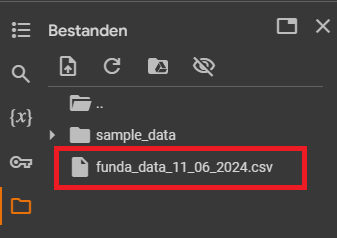

In [ ]:
# !pip install funda-scraper

# from funda_scraper import FundaScraper

In [ ]:
# #-- Setup a scraper object for Utrecht, run it, and save the result in a dataframe
# #>> Many code is repeated purposefully here (to run the cells separately)
# utrecht_scraper = FundaScraper(area="utrecht", want_to="buy", n_pages=170)
# utrecht_df = utrecht_scraper.run()

In [ ]:
# #-- Setup a scraper object for Amsterdam, run it, and save the result in a dataframe
# amsterdam_scraper = FundaScraper(area="amsterdam", want_to="buy", n_pages=170)
# amsterdam_df = amsterdam_scraper.run()

In [ ]:
# #-- Setup a scraper object for Rotterdam, run it, and save the result in a dataframe
# rotterdam_scraper = FundaScraper(area="rotterdam", want_to="buy", n_pages=170)
# rotterdam_df = rotterdam_scraper.run()

In [ ]:
# #-- Setup a scraper object for The Hague, run it, and save the result in a dataframe
# the_hague_scraper = FundaScraper(area="den haag", want_to="buy", n_pages=170)
# the_hague_df = the_hague_scraper.run()

In [ ]:
# #-- Setup a scraper object for Eindhoven, run it, and save the result in a dataframe
# eindhoven_scraper = FundaScraper(area="eindhoven", want_to="buy", n_pages=170)
# eindhoven_df = eindhoven_scraper.run()

In [ ]:
# #-- Setup a scraper object for Breda, run it, and save the result in a dataframe
# breda_scraper = FundaScraper(area="breda", want_to="buy", n_pages=170)
# breda_df = breda_scraper.run()

In [ ]:
# # Concatenate the separate DataFrames
# df = pd.concat([utrecht_df, amsterdam_df, rotterdam_df, the_hague_df, eindhoven_df, breda_df], ignore_index=True)

# # Save the scraped data in csv format
# df.to_csv('funda_data_11_06_2024.csv', index=False)

# # Here we used a converter because the house descriptions were not UTF-8 format. Link:
# # https://www.virtualbadge.io/resources/utf-8-converter-for-csv-files

# # Use Google Colab library to download the file locally
# files.download('funda_data_11_06_2024_UTF_8.csv')

# Data Preprocessing

In [ ]:
## First we load the CSV into a pandas DataFrame
df = pd.read_csv('funda_data_11_06_2024_UTF_8.csv',on_bad_lines='skip', delimiter=';')

## After inspecting the dataframe, I saw a lot of extra columns.
## After running this (commented) code, I found out that these columns do not contain any relevant data
#-----------------------------------------
# for column in df.columns:
#     unique_values = df[column].unique()
#     # Print only the first 10 unique values for brevity
#     print(f"Unique values in '{column}' (showing up to 10 values): {unique_values[:10]}")

## Thus from now on we will only keep our columns for which we know that they contain useful data
columns_to_keep = ['url', 'house_id', 'city', 'house_type', 'building_type', 'price', 'price_m2', 'room', 'bedroom', 'bathroom', 'living_area', 'energy_label', 'zip', 'address', 'year_built', 'house_age', 'descrip', 'photo']
df = df[columns_to_keep]

## Now let's (practically) check out the unique values of the columns
dont_check = ['url', 'house_id', 'price', 'price_m2', 'zip', 'address', 'descrip', 'photo']
for column in df.columns:
    if (column not in dont_check):
      unique_values = df[column].unique()
      print('-'*50)
      ## Omitting url values (this is not a perfect dataset, this will be handled)
      for value in unique_values:
        if (isinstance(value, str) and 'http' not in value):
          print(f"Unique value in '{column}': {value}")
      print('-'*50)

#-- Interesting print statements
## Unique value in 'year_built': 0
## Unique value in 'house_age': -1.0
## Unique value in 'house_age': -2.0
## Unique value in 'house_age': -3.0


<ipython-input-22-78c0f9f6dbe4>:2: DtypeWarning: Columns (283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('funda_data_11_06_2024_UTF_8.csv',on_bad_lines='skip', delimiter=';')


--------------------------------------------------
Unique value in 'city': utrecht
Unique value in 'city': amsterdam
Unique value in 'city': rotterdam
Unique value in 'city': den-haag
Unique value in 'city': eindhoven
Unique value in 'city': breda
--------------------------------------------------
--------------------------------------------------
Unique value in 'house_type': huis
Unique value in 'house_type': appartement
--------------------------------------------------
--------------------------------------------------
Unique value in 'building_type': Bestaande bouw
Unique value in 'building_type': Nieuwbouw
--------------------------------------------------
--------------------------------------------------
Unique value in 'room': 6
Unique value in 'room': 3
Unique value in 'room': 2
Unique value in 'room': 5
Unique value in 'room': 4
Unique value in 'room': 7
Unique value in 'room': 8
Unique value in 'room': 1
Unique value in 'room': 11
Unique value in 'room': 14
Unique value in 

In [ ]:
#-- Let's use 'house_id' to remove duplicate entries
df = df.drop_duplicates(subset='house_id', keep=False)

#-- Next, we will drop some features. Specifically, we drop:
#** 'url'- because it's too random
#** 'house_id' - because it's just an identifier
#** 'photo' - since it is also a url
#** 'descrip' - since we will only use numerical and categorical features
#** 'address' - for the same reason as descrip
#** 'price_m2' - Since our aim is to predict price. If we already know the price per m2, there is no point in predicting price, since it can be derived from space_m2 * price_m2
df = df.drop(['url', 'house_id', 'photo', 'descrip', 'address', 'price_m2'], axis=1)

#-- Now, let's make sure we have the right data types
# Convert columns to string type
columns_to_string = ['city', 'house_type', 'building_type', 'energy_label']
df[columns_to_string] = df[columns_to_string].astype(str)

# Convert these to int type, with na for non-convertible vals
columns_to_numeric = ['price', 'room', 'bedroom', 'bathroom', 'living_area', 'year_built', 'house_age']
df[columns_to_numeric] = df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')

In [ ]:
print(f"N entries before handling missing/illogical values: {len(df)}")

## From the previous code block we found some illogical values
# Filter out rows where 'year_built' is 0
df = df[df['year_built'] != 0]

# Filter out rows where 'house_age' is negative
df = df[df['house_age'] >= 0]


#-- Next, let's handle missing values
# First we look at the ratio of na values
print(df.isna().sum())

# Ratio of na values seems minor compared to our original N, let's drop all rows with na and see
df = df.dropna()
print(f"N entries after handling missing/illogical values: {len(df)}")

## From N = 9952 to N = 8648, which is manageable


N entries before handling missing/illogical values: 9952
city             0
house_type       0
building_type    0
price            0
room             0
bedroom          0
bathroom         0
living_area      0
energy_label     0
zip              0
year_built       0
house_age        0
dtype: int64
N entries after handling missing/illogical values: 8648


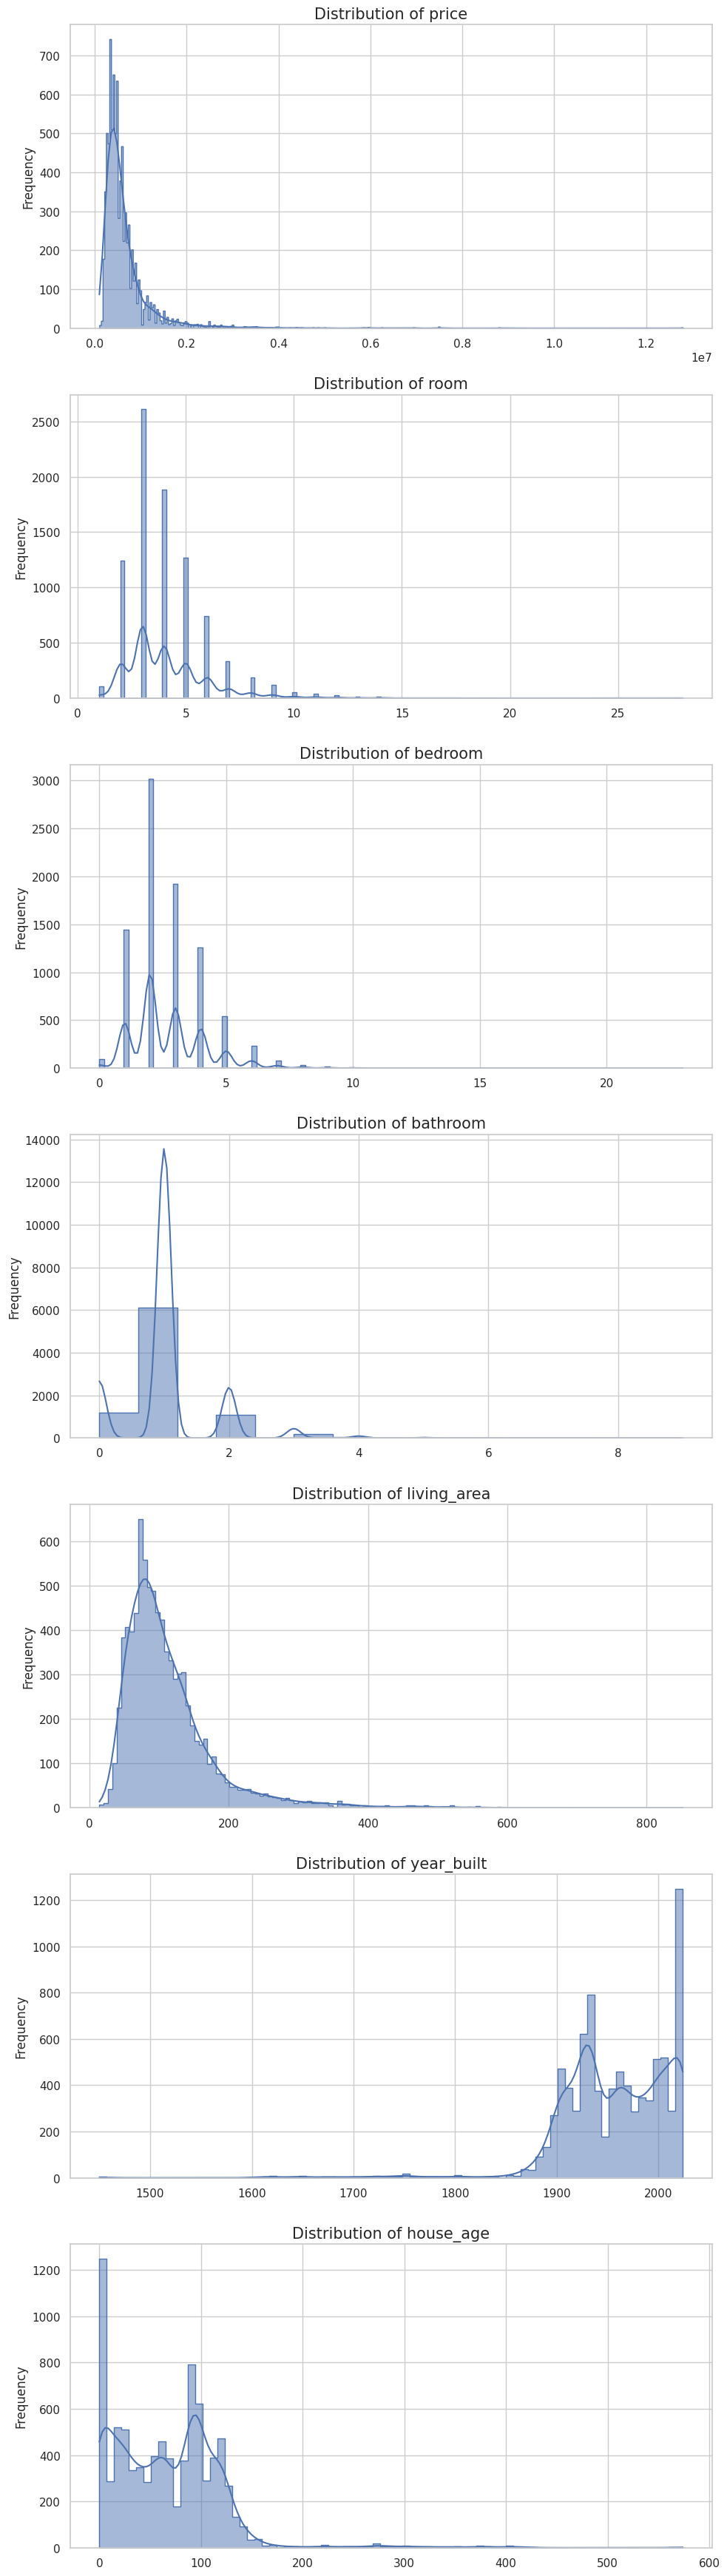

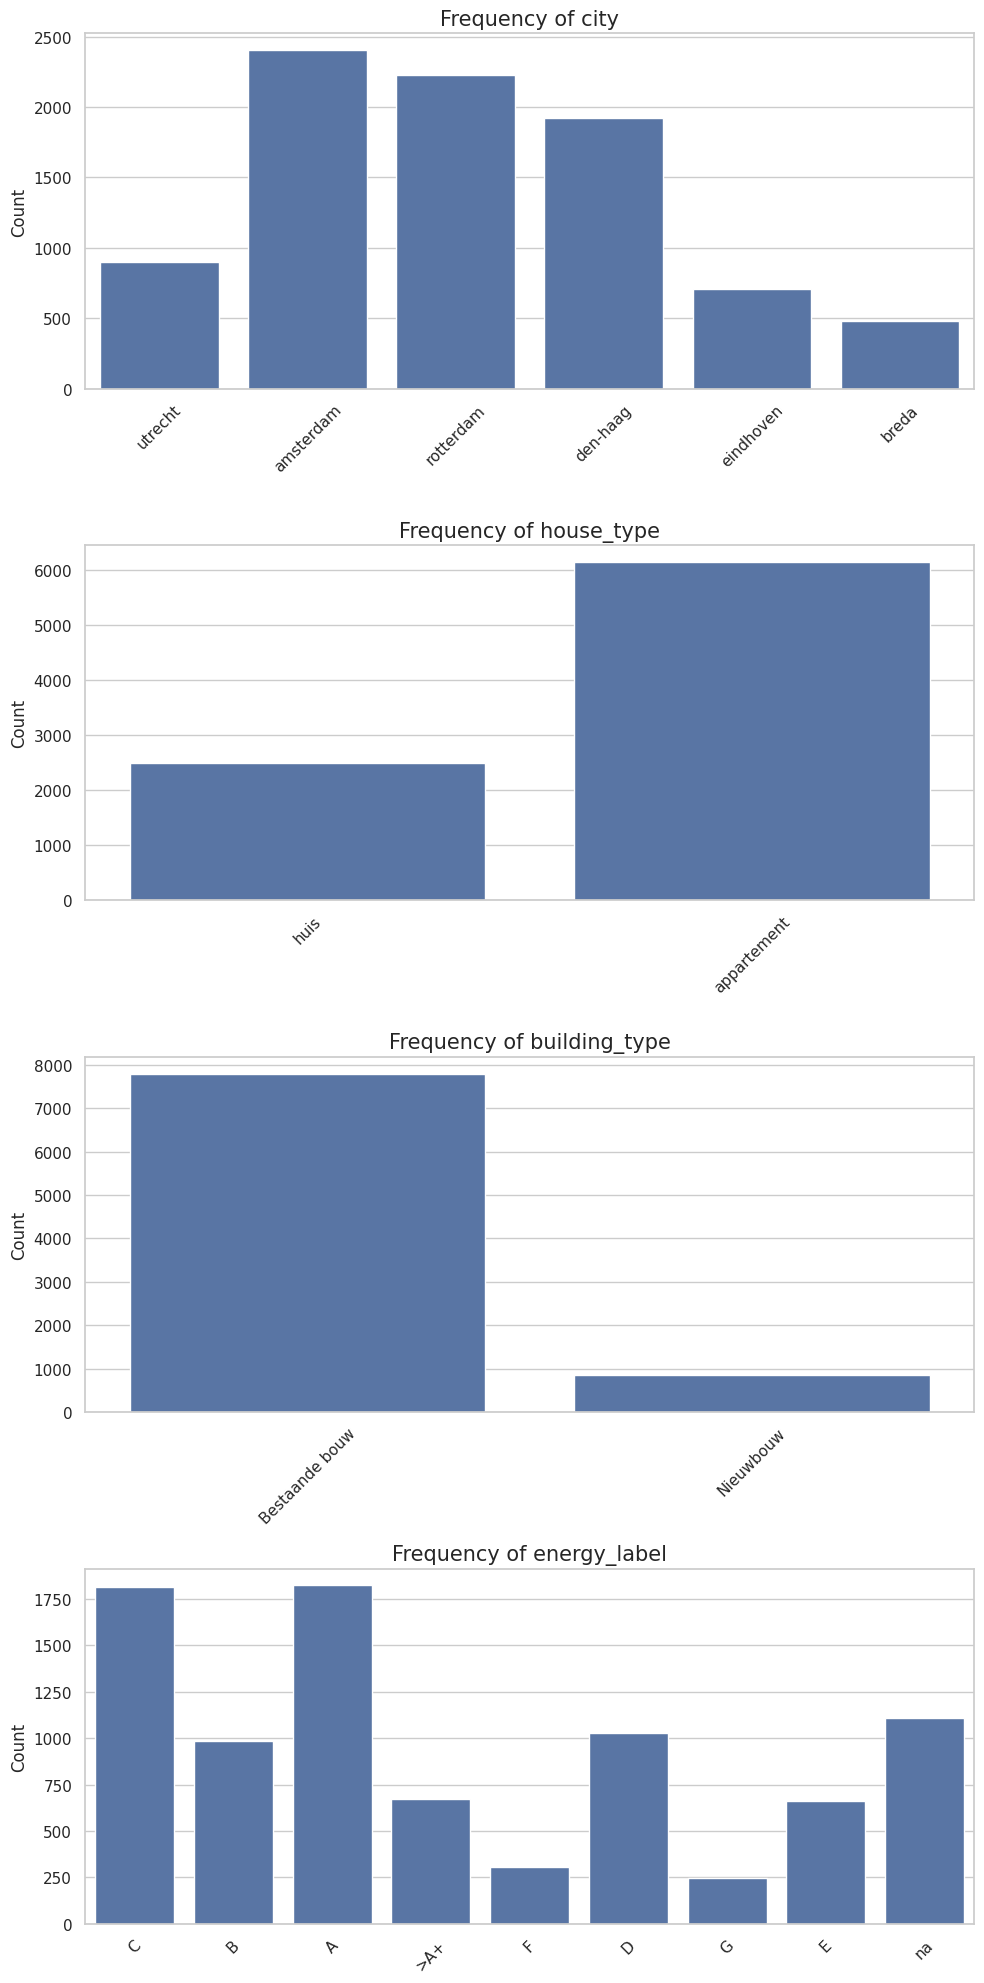

In [ ]:
#-- Next lets visualize the feature value distributions for some of the features

# Styling
sns.set(style="whitegrid")

# Distinguish between numeric and categorical features
numeric_features = ['price', 'room', 'bedroom', 'bathroom', 'living_area', 'year_built', 'house_age']
categorical_features = ['city', 'house_type', 'building_type', 'energy_label']

def plot_feature_distributions():
  # Plotting histograms for numeric columns
  fig, axes = plt.subplots(nrows=len(numeric_features), ncols=1, figsize=(10, 5 * len(numeric_features)))
  for i, col in enumerate(numeric_features):
      sns.histplot(df[col], ax=axes[i], kde=True, element='step')
      axes[i].set_title(f'Distribution of {col}', fontsize=15)
      axes[i].set_xlabel('')
      axes[i].set_ylabel('Frequency')

  # Adjust layout
  plt.tight_layout()
  plt.show()

  # Plotting bar charts for categorical columns
  fig, axes = plt.subplots(nrows=len(categorical_features), ncols=1, figsize=(10, 5 * len(categorical_features)))
  for i, col in enumerate(categorical_features):
      sns.countplot(x=col, data=df, ax=axes[i])
      axes[i].set_title(f'Frequency of {col}', fontsize=15)
      axes[i].set_xlabel('')
      axes[i].set_ylabel('Count')
      for label in axes[i].get_xticklabels():
          label.set_rotation(45)  # Rotate labels to avoid overlap

  # Adjust layout
  plt.tight_layout()
  plt.show()

plot_feature_distributions()

I decided to take a different approach (based on performance on the train and dev set), hence I commented out the 2 code blocks below.

In [ ]:
# #-- We need to handle outliers in the numerical features, we will use the interquartile range method for this

# # Loop through numeric features
# for feature in numeric_features:
#   # Defining the first and third quartile, to set the IQR
#   Q1 = df[feature].quantile(0.25)
#   Q3 = df[feature].quantile(0.75)
#   IQR = Q3 - Q1

#   # Defining bounds
#   lower_bound = Q1 - 1.5 * IQR
#   upper_bound = Q3 + 1.5 * IQR

#   # Capping
#   df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
#   df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])

# #-- Now let's look at the feature distributions again
# plot_feature_distributions()

In [ ]:
# #-- From inspecting the feature value distributions, we see that 'price', 'price_m2', and 'living_area' are still pretty skewed.
# # Thus we will apply log scaling to these features.
# df['log_price'] = np.log1p(df['price'])
# df['log_price_m2'] = np.log1p(df['price_m2'])
# df['log_living_area'] = np.log1p(df['living_area'])

# # Remove the (non-log scaled variants)
# df = df.drop(['price', 'price_m2', 'living_area'], axis=1)


# # Update numeric_features
# numeric_features = ['log_price', 'log_price_m2', 'room', 'bedroom', 'log_living_area', 'year_built', 'house_age']

# #-- We also see that for energy label there are quite some entries with value 'na'.
# # Because it's a significant portion of the data, we will fill these values with the most common value
# most_common = df['energy_label'].mode()[0]
# df['energy_label'] = df['energy_label'].replace('na', most_common)

# #-- Finally, for our 'bathroom' feature, we see that the value is always equal to 1.
# # This suggests an issue with the scraping/entry of this feature. Thus, we drop it.
# df = df.drop('bathroom', axis=1)


# #-- Next let's plot the distributions again
# plot_feature_distributions()

In [ ]:
#-- Because our data is skewed due to some outliers, we will drop those outliers
print(f"N entries before dropping outliers: {len(df)}")
df = df[df['price'] <= 1000000]
print(f"N entries after dropping outliers: {len(df)}")

#-- We also see that for energy label there are quite some entries with value 'na'.
# Because it's a significant portion of the data, we will fill these values with the most common value
df = df.copy()
most_common = df['energy_label'].mode()[0]
df['energy_label'] = df['energy_label'].replace('na', most_common)

#-- Finally, for our 'bathroom' feature, we see that the value is always equal to 1.
# This suggests an issue with the scraping/entry of this feature. Thus, we drop it.
df = df.drop('bathroom', axis=1)

N entries before dropping outliers: 8648
N entries after dropping outliers: 7585


In [ ]:
## ------------------------- Feature Engineering ---------------------------- ##

#-- Because I suspect the relation between the living area and the number of rooms to affect price, I will engineer a new feature
df['room_X_living_area'] = df['room'] * df['living_area']

#-- How many of the rooms are bedrooms?
df['bedroom_ratio'] = df['bedroom'] / df['room']

# #-- Likewise, I think the number of rooms multiplied by number of bedrooms could be indicative of price
df['room_X_bedroom'] = df['room'] * df['bedroom']

# #-- Let's generalize for a moment. Generally speaking, more bedrooms is a perk of a house (space for a bigger family). Same goes for  rooms and living area.
df['room_X_bedroom_X_living_area'] = df['room'] * df['bedroom'] * df['living_area']

In [ ]:
#-- Update numeric_features and categorical_features
# (leave out price, as we do not wan to scale it)
numeric_features = ['room', 'bedroom', 'zip', 'year_built', 'house_age', 'price', 'living_area', 'room_X_living_area', 'bedroom_ratio', 'room_X_bedroom', 'room_X_bedroom_X_living_area']
categorical_features = ['city', 'house_type', 'building_type', 'energy_label']


#-- Now we need to:
#>> One-hot encode the categorical features
#>> Scale the numerical features
#>> Reset the indeces (since we droppped some entries)

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Apply the transformations
df_processed = pipeline.fit_transform(df)

# Convert the resulting array to a pandas DataFrame
column_names = numeric_features + list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
df_processed = pd.DataFrame(df_processed, columns=column_names)

# Reset the indices
df_processed.reset_index(drop=True, inplace=True)

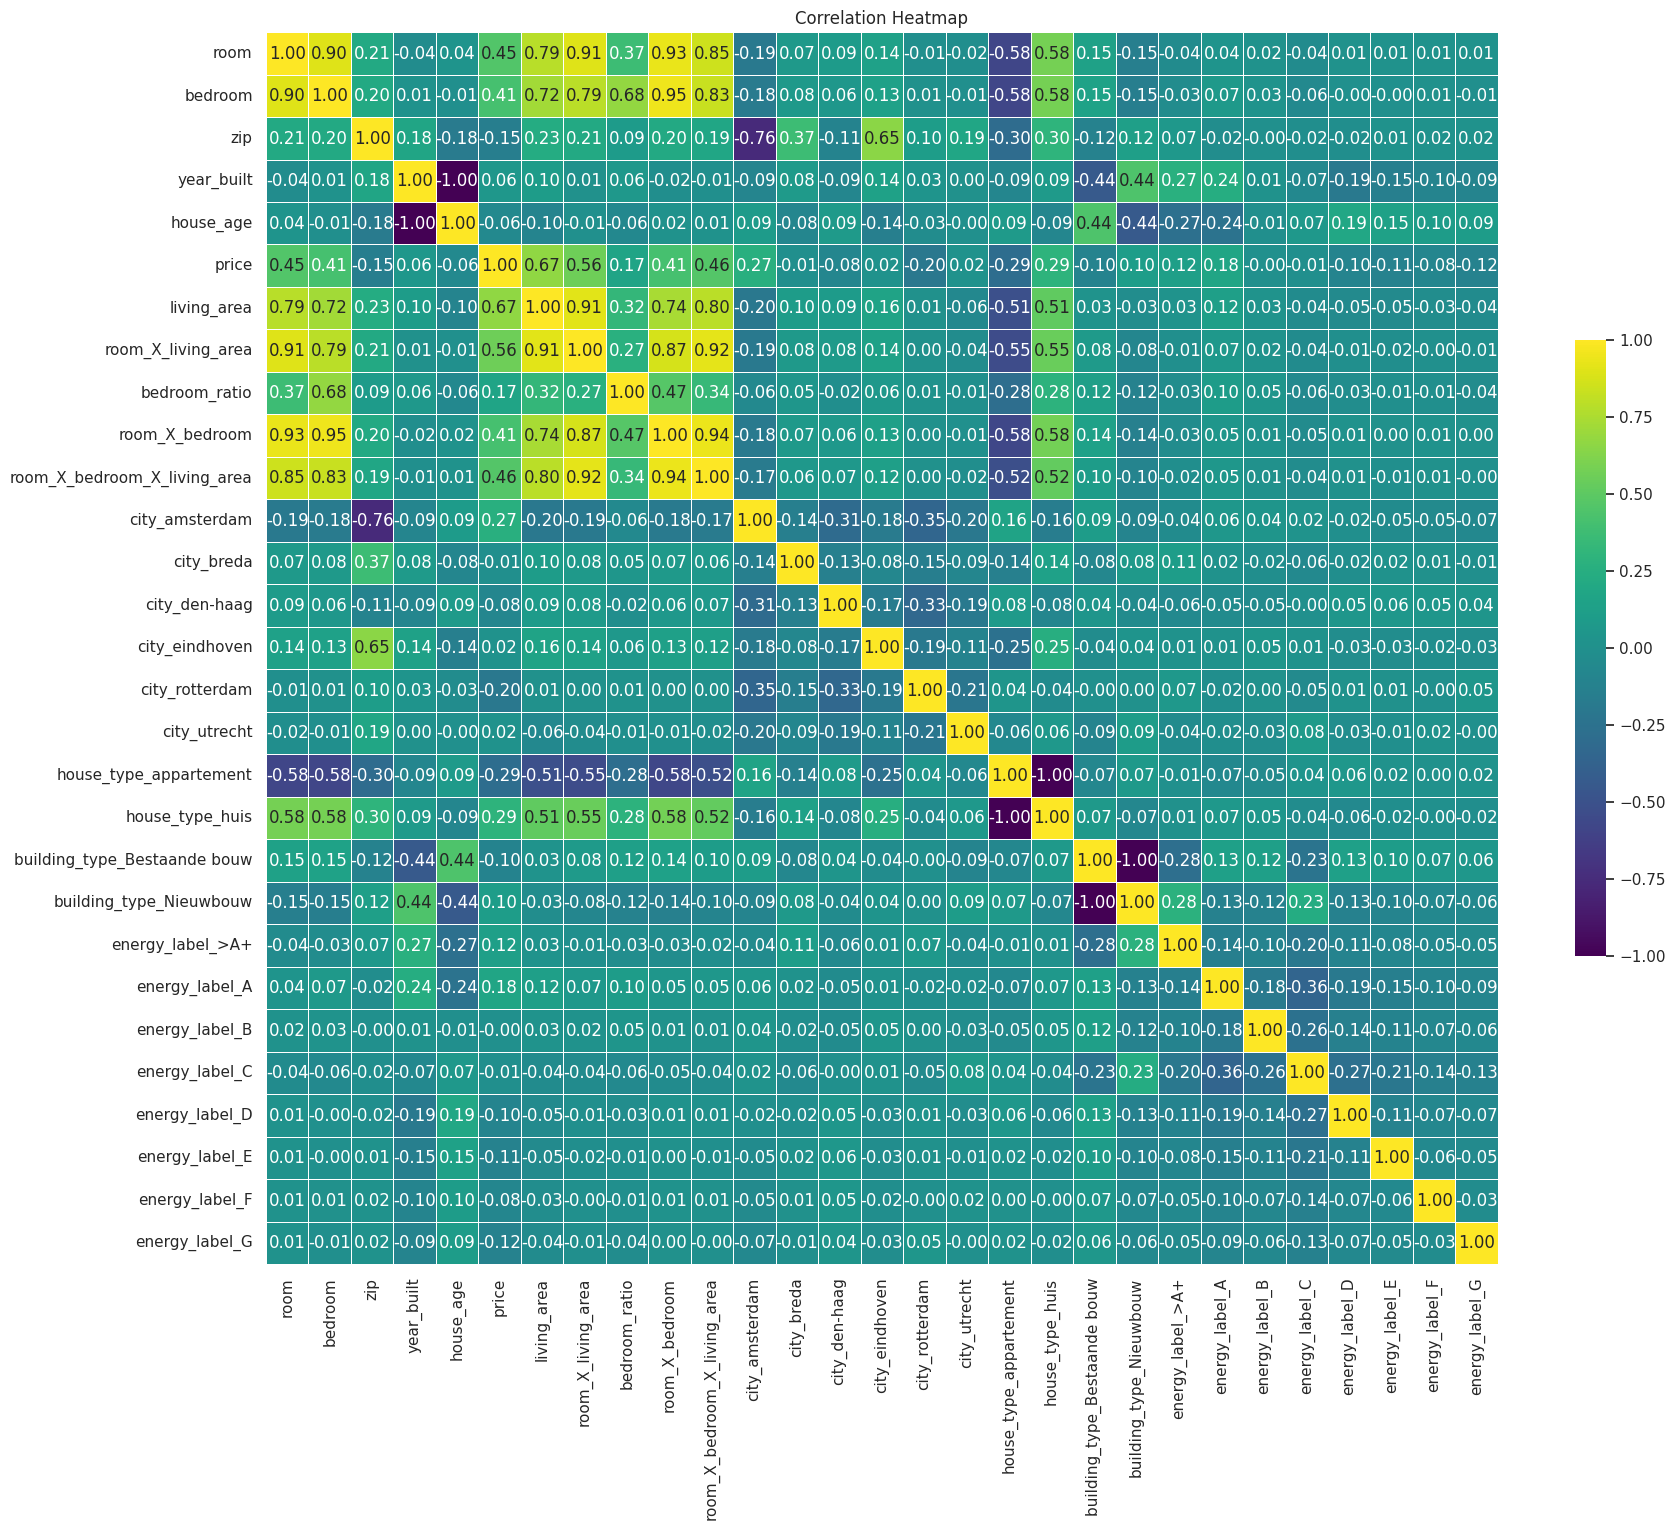

In [ ]:
## Heatmap plot for inpecting correlations
corr_matrix = df_processed.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
#>> Moving on, we will be splittig our proccessed dataset
#>> 70% train - 15%dev - 15%test

#-- Separate our target feature from the training features
X = df_processed.drop('price', axis=1)
y = df_processed['price']

#-- Separate out the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

#-- Now split the remaining 85% data into train and dev sets
# Calculating 15% of 85% gives us approximately 0.176 for the validation set to achieve a 15% of the overall data
X_train, X_dev, y_train, y_dev = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

print("Train set size:", X_train.shape)
print("Dev set size:", X_dev.shape)
print("Test set size:", X_test.shape)

Train set size: (5312, 28)
Dev set size: (1135, 28)
Test set size: (1138, 28)


# Training the model

In [ ]:
## ------------------- Hyperparameter Optimization -------------------------- ##

class MyHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units1', min_value=16, max_value=128, step=32),
                        input_dim=self.input_dim,
                        activation=hp.Choice('activation1', values=['relu', 'tanh', 'sigmoid']),
                        kernel_initializer=initializers.HeNormal() # Improved initialization
                  ))
        model.add(Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(units=hp.Int('units2', min_value=16, max_value=64, step=16),
                        activation=hp.Choice('activation2', values=['relu', 'tanh', 'sigmoid'])))
        model.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(units=hp.Int('units3', min_value=8, max_value=32, step=8),
                        activation=hp.Choice('activation3', values=['relu', 'tanh', 'sigmoid'])))
        model.add(Dense(1, activation='linear'))

        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                      loss='mean_squared_error')
        return model

hypermodel = MyHyperModel(input_dim=X_train.shape[1])

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='tuner',
    project_name='param_optimization'
)

tuner.search(x=X_train, y=y_train, epochs=100, validation_data=(X_dev, y_dev), verbose=2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best hyperparameters are:
- Units Layer 1: {best_hps.get('units1')}
- Activation Layer 1: {best_hps.get('activation1')}
- Dropout Layer 1: {best_hps.get('dropout1')}
- Units Layer 2: {best_hps.get('units2')}
- Activation Layer 2: {best_hps.get('activation2')}
- Dropout Layer 2: {best_hps.get('dropout2')}
- Units Layer 3: {best_hps.get('units3')}
- Activation Layer 3: {best_hps.get('activation3')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 10 Complete [00h 01m 30s]
val_loss: 0.22796247899532318

Best val_loss So Far: 0.22796247899532318
Total elapsed time: 00h 23m 07s

The best hyperparameters are:
- Units Layer 1: 80
- Activation Layer 1: relu
- Dropout Layer 1: 0.2
- Units Layer 2: 32
- Activation Layer 2: relu
- Dropout Layer 2: 0.2
- Units Layer 3: 24
- Activation Layer 3: sigmoid
- Learning Rate: 0.00040287974361334



In [ ]:
# Use the best hyperparams to configure the model
n_features = X_train.shape[1]
learning_rate = best_hps.get('learning_rate')
batch_size = 32
epochs = 100
activation_func = 'relu'

# Build the model
model = Sequential()
model.add(Dense(best_hps.get('units1'), input_dim=n_features, activation=best_hps.get('activation1')))   # Hidden layer one
model.add(Dropout(best_hps.get('dropout1')))                                                             # Dropout regularization (to prevent overfitting)
model.add(Dense(best_hps.get('units2'), activation=best_hps.get('activation2')))                         # Second hidden layer
model.add(Dropout(best_hps.get('dropout2')))                                                             # Dropout layer
model.add(Dense(best_hps.get('units3'), activation=best_hps.get('activation3')))                         # Third hidden layer
model.add(Dense(1, activation='linear'))                                                                 # Output layer with linear activation for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

history = model.fit(X_train, y_train,
                    validation_data=(X_dev, y_dev),
                    epochs=100,
                    batch_size=batch_size,
                    verbose=2)


Epoch 1/100
166/166 - 2s - loss: 1.0248 - val_loss: 0.5682 - 2s/epoch - 11ms/step
Epoch 2/100
166/166 - 1s - loss: 0.4498 - val_loss: 0.3210 - 532ms/epoch - 3ms/step
Epoch 3/100
166/166 - 1s - loss: 0.3400 - val_loss: 0.2713 - 524ms/epoch - 3ms/step
Epoch 4/100
166/166 - 1s - loss: 0.3174 - val_loss: 0.2607 - 657ms/epoch - 4ms/step
Epoch 5/100
166/166 - 1s - loss: 0.3049 - val_loss: 0.2527 - 548ms/epoch - 3ms/step
Epoch 6/100
166/166 - 1s - loss: 0.2895 - val_loss: 0.2463 - 591ms/epoch - 4ms/step
Epoch 7/100
166/166 - 0s - loss: 0.2845 - val_loss: 0.2459 - 401ms/epoch - 2ms/step
Epoch 8/100
166/166 - 0s - loss: 0.2755 - val_loss: 0.2438 - 352ms/epoch - 2ms/step
Epoch 9/100
166/166 - 0s - loss: 0.2760 - val_loss: 0.2412 - 343ms/epoch - 2ms/step
Epoch 10/100
166/166 - 0s - loss: 0.2710 - val_loss: 0.2403 - 366ms/epoch - 2ms/step
Epoch 11/100
166/166 - 0s - loss: 0.2627 - val_loss: 0.2406 - 330ms/epoch - 2ms/step
Epoch 12/100
166/166 - 0s - loss: 0.2662 - val_loss: 0.2386 - 340ms/epoch - 

In [ ]:
test_loss = model.evaluate(X_test, y_test, verbose=2)
print(f"Test MSE: {test_loss}")


36/36 - 0s - loss: 0.1838 - 59ms/epoch - 2ms/step
Test MSE: 0.18379242718219757


# Remarks on the results

I am not happy with the resulting loss of 0.18 on the test set. For the application of predicting house prices, this is unacceptable. My first instinct is not to blame the data, so I have tried the following (including different combinations):
- Using a tuner to optimize hyperparameters. I experimented with different activation functions, dense layer sizes and dropout values, which improved the performance a bit.
- Using the IQR method for outliers (instead of dropping them)
- Experimented with different model architectures. I thought that stacking layers might increase performance, but came to the conclusion that this would be more effective if I had more data. With the amount of data available, with a more complex model architecture, I risk overfitting the model to the train set.
- Log scaling skewed numeric features. While this at first seemed better (0.15 loss on the train set), I realized that the error was on predicting the log scaled price. This means that when taking the rmse, the actual loss would be around 0.4, or 40%.

After trying different approaches, I came to the conclusion that to effectively train a deep neural network I need:
- A lot more data
- Less sparse data (to have data with favorable distributions)


To support my hypothesis I decided to use the same data on a different type of model (XGBoost) which works better with sparse/smaller datasets and is less affected by outliers. Below you can see the results achieved with XGBoost with minimal hyperparam tweaking.

# Comparing results with a tree-based model (XGBoost)

In [ ]:
# Convert the dataset into an optimized data structure called Dmatrix
dtrain = xgb.DMatrix(data=X_train, label=y_train)
ddev = xgb.DMatrix(data=X_dev, label=y_dev)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# Define the XGBoost model parameters
params = {
    'objective': 'reg:squarederror',  # Use regression with squared error
    'max_depth': 7,                   # Depth of the tree
    'learning_rate': 0.1,             # Epsilon
    'n_estimators': 100,              # Number of trees to build
    'subsample': 0.9,                 # Sampling of the dataset to prevent overfitting
    'colsample_bytree': 0.8,          # Subsample ratio of columns when constructing each tree
    'reg_alpha': 0.7,                 # L1 regularization on weights
    'reg_lambda': 1.0,                # L2 regularization on weights
    'seed': 42                         # For reproducibility
}

# Training the model
model_xg = xgb.train(params, dtrain, num_boost_round=100, evals=[(ddev, 'dev')], early_stopping_rounds=10)

# Predictions
y_pred_train = model_xg.predict(dtrain)
y_pred_dev = model_xg.predict(ddev)
y_pred_test = model_xg.predict(dtest)

# Evaluating model performance
mse_train = mean_squared_error(y_train, y_pred_train)
mse_dev = mean_squared_error(y_dev, y_pred_dev)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Train MSE: {mse_train}")
print(f"Dev MSE: {mse_dev}")
print(f"Test MSE: {mse_test}")

[0]	dev-rmse:0.96195
[1]	dev-rmse:0.89539
[2]	dev-rmse:0.84064
[3]	dev-rmse:0.78804
[4]	dev-rmse:0.74348
[5]	dev-rmse:0.70346
[6]	dev-rmse:0.66845
[7]	dev-rmse:0.63845
[8]	dev-rmse:0.61150
[9]	dev-rmse:0.58737
[10]	dev-rmse:0.56601
[11]	dev-rmse:0.54695
[12]	dev-rmse:0.53084
[13]	dev-rmse:0.51659
[14]	dev-rmse:0.50618
[15]	dev-rmse:0.49477


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:51:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	dev-rmse:0.48570
[17]	dev-rmse:0.47820
[18]	dev-rmse:0.46959
[19]	dev-rmse:0.46353
[20]	dev-rmse:0.45760
[21]	dev-rmse:0.45228
[22]	dev-rmse:0.44865
[23]	dev-rmse:0.44400
[24]	dev-rmse:0.43926
[25]	dev-rmse:0.43698
[26]	dev-rmse:0.43399
[27]	dev-rmse:0.43266
[28]	dev-rmse:0.43032
[29]	dev-rmse:0.42743
[30]	dev-rmse:0.42599
[31]	dev-rmse:0.42339
[32]	dev-rmse:0.42219
[33]	dev-rmse:0.41960
[34]	dev-rmse:0.41891
[35]	dev-rmse:0.41588
[36]	dev-rmse:0.41362
[37]	dev-rmse:0.41159
[38]	dev-rmse:0.41148
[39]	dev-rmse:0.41062
[40]	dev-rmse:0.40903
[41]	dev-rmse:0.40759
[42]	dev-rmse:0.40621
[43]	dev-rmse:0.40585
[44]	dev-rmse:0.40497
[45]	dev-rmse:0.40434
[46]	dev-rmse:0.40251
[47]	dev-rmse:0.40120
[48]	dev-rmse:0.40052
[49]	dev-rmse:0.39973
[50]	dev-rmse:0.39932
[51]	dev-rmse:0.39929
[52]	dev-rmse:0.39905
[53]	dev-rmse:0.39838
[54]	dev-rmse:0.39838
[55]	dev-rmse:0.39812
[56]	dev-rmse:0.39766
[57]	dev-rmse:0.39681
[58]	dev-rmse:0.39647
[59]	dev-rmse:0.39545
[60]	dev-rmse:0.39516
[61]	dev-r

With very minimal tweaking XGBoost actually outperformed the neural network architecture (on the train, dev & test set), supporting the hypothesis that to effectively train a neural network we need more data and less sparse data.

# Using XAI methods to explain some predictions of the NN model

### LIME


In [ ]:
#-- First we create an explainer object
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['Predicted Value'],
    mode='regression'
)

#-- Then we use it to explain instances 4 & 120
instance_1_idx = 4
instance_2_idx = 120

#-- Let us look at instance 4 first
explanation_1 = explainer.explain_instance(data_row=X_test.iloc[instance_1_idx],
                                         predict_fn=model.predict)

explanation_1.show_in_notebook(show_table=True)

#-- We see that the predicted value is leaning towards the minimum, very low.
# We see that the living area being below a certain threshold had a very large negative contribution to the prediction
# We can also see that the house not being new (building_type_Nieuwbouw = 0), had a decent negative contibution on the prediction.
# We also see that the house not having a very bad energy rating (rating G), had a slight positive contribution on the price prediction.

#-- How accurate is the prediction?
print(f"Gold Label for instance 4: {y_test.iloc[instance_1_idx]}")

# While there is quite a large error (4%), we do see that the model was right in predicing a low value for this instance



157/157 [==============================] - 0s 2ms/step


Gold Label for instance 4: -1.3957563284091818


In [ ]:
# Let us now look at instance 120

explanation_2 = explainer.explain_instance(data_row=X_test.iloc[instance_2_idx],
                                         predict_fn=model.predict)

explanation_2.show_in_notebook(show_table=True)

#-- We see that the predicted value is a bit above the mean.
# We see that the living area being over a certain threshold had a very large positive contribution to the prediction.
# We can also see that the feature we engineered (room * living area) being over a threshold had a decent positive contribution.
# Again the house not being new had a decent negative contribtion on the price prediction. So far these explanations make sense

#-- How accurate is the prediction?
print(f"Gold Label for instance 120: {y_test.iloc[instance_2_idx]}")

# Again, quite a big error (21%), we do see that the model was right in predicting a value between the mean and high end of the range


157/157 [==============================] - 0s 2ms/step


Gold Label for instance 120: 0.934746390470939


### SHAP

In [ ]:
#-- Let us now generate SHAP explanations for the same 2 instances

shap.initjs()

# Create a SHAP Deep Explainer
shap_explainer = shap.DeepExplainer(model, X_train.values[:100])  # Use 100 background examples from training set

# Select specific instances for explanation
instances_to_explain = X_test.iloc[[instance_1_idx, instance_2_idx]].values

# Compute SHAP values for these instances
shap_values = shap_explainer.shap_values(instances_to_explain)

# Convert the expected_value to a plain Python float if needed (for serialization)
if isinstance(shap_explainer.expected_value, np.ndarray):
    expected_value = float(shap_explainer.expected_value[0])
else:
    expected_value = float(shap_explainer.expected_value.numpy())

# Simplify SHAP values
shap_values = [np.squeeze(val) for val in shap_values]

# Visualize the SHAP explanation for the first instance
print("Visualizing SHAP explanation for the first instance...")
shap.force_plot(
    expected_value,
    shap_values[0],
    instances_to_explain[0],
    feature_names=X_test.columns.tolist()
)

#-- When comparing against the base value, we see that:
#-- The living area had a large negative contribution on the prediction (decreasing the price). In line w/ the LIME explanation
#-- The no. of bedrooms had a small positive contribution
#-- The house being situated in the Hague, driving down the price prediction
#-- The feature we engineered (room * bedroom * living_area) had some positive contribution on the price prediction

Visualizing SHAP explanation for the first instance...


<ipython-input-71-91ac55058665>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  expected_value = float(shap_explainer.expected_value.numpy())


In [ ]:
shap.initjs()


# Visualize the SHAP explanations for the second instance
print("Visualizing SHAP explanation for the second instance...")
shap.force_plot(
    expected_value,
    shap_values[1],
    instances_to_explain[1],
    feature_names=X_test.columns.tolist()
)

#-- When comparing against the base value, we see that:
#-- The living area had a large positive contribution on the prediction (increasing the price). In line w/ the LIME explanation
#-- The house age had some positive contribution on the prediction
#-- The house being situated in the Hague, driving down the price prediction
#-- The feature we engineered (room * bedroom) had some negative contribution for this instance

Visualizing SHAP explanation for the second instance...
